# Pooled Motif Run Analysis
### Nathan Alam 6/15/20

Ran on the following genomes:

In [1]:
import os
import json
import sqlite3
import re

In [2]:
theStuff = ""
with open("pooledMotifs.json") as file:
    theStuff = json.load(file)

In [3]:
print("Total peptides found: " + str(theStuff["peptides"]))
print("Pattern used: " + str(theStuff["pattern"]))
print("Cutoff rank: " + str(theStuff["cutoff"]))
print("Time elapsed: " + str(theStuff["totalTime"] / 3600) + " hours")
print("Genomes mined: " + str(len(theStuff["input"])))
print("Average time per genome: " + str(theStuff["totalTime"] / len(theStuff["input"])) + " seconds")

Total peptides found: 21414
Pattern used: M[A-Z]{15,45}T[A-Z][A-Z]{6,8}[DE][A-Z]{5,30}\*
Cutoff rank: 10.0
Time elapsed: 43.44405295014381 hours
Genomes mined: 15256
Average time per genome: 10.25161186552948 seconds


In [4]:
# regular expression function for regular expression search
def regexp(expr, item):
    reg = re.compile(expr)
    return reg.search(item) is not None

In [5]:
conn = sqlite3.connect('matches.db')
conn.create_function("REGEXP", 2, regexp)
c = conn.cursor()

selectionStringGenomes = "SELECT DISTINCT genome FROM lassopeptides WHERE runname is 'pooledMotifs'"
distinctGenomes = []
for row in c.execute(selectionStringGenomes):
    distinctGenomes.append(row[0])

c.close()

In [6]:
print("Number of genomes with lasso peptides: " + str(len(distinctGenomes)))

Number of genomes with lasso peptides: 109


In [7]:
conn = sqlite3.connect('matches.db')
conn.create_function("REGEXP", 2, regexp)
c = conn.cursor()

selectionStringGenomes = "SELECT DISTINCT sequence, rank, genome FROM lassopeptides WHERE runname is 'pooledMotifs'"
peptides = []
for row in c.execute(selectionStringGenomes):
    peptides.append({
        "sequence": row[0],
        "rank": row[1],
        "genome": row[2],
    })
c.close()

In [8]:
print("DISTINCT lasso peptide hits: " + str(len(peptides)))

DISTINCT lasso peptide hits: 19579


In [35]:
genomeDict = {}
genomeArr = []
for genome in distinctGenomes:
    peptideArr = []
    runningSum = 0
    for peptide in peptides:
        if(peptide["genome"] == genome):
            peptideArr.append(peptide)
            runningSum += peptide["rank"]
    genomeArr.append({
            "genome": genome,
            "average" : (1.0 * runningSum) / len(peptideArr),
            "count": len(peptideArr)
        }
    )
    genomeDict.update({
        genome: peptideArr
    })

In [36]:
genomeArr.sort(reverse=True, key=lambda i: i['average'])

In [37]:
for gen in genomeDict.keys():
    genomeDict[gen].sort(reverse=True, key=lambda i: i["rank"])

In [39]:
for gen in genomeDict.keys():
    rankList = []
    peptideList = []
    for peptide in genomeDict[gen]:
        rankList.append(peptide["rank"])
        peptideList.append(peptide["sequence"])
    genomeDict.update({
        gen: {
            "ranks": rankList,
            "peptides": peptideList
        }
    })

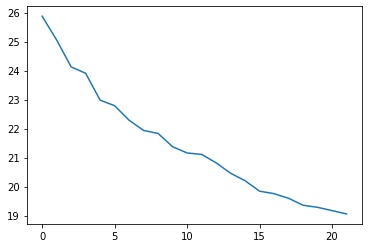

In [40]:
y = genomeDict[genomeArr[1]["genome"]]["ranks"]
x = range(0, len(y))

import matplotlib.pyplot as plt
plt.plot(y)

In [41]:
with open("allGenomes.txt", 'w') as file:
    file.write(json.dumps(theStuff["input"]))

In [42]:
with open("genomeHits.txt", 'w') as file:
    file.write(json.dumps(genomeArr))

In [43]:
import pandas as pd

In [46]:
precsv = pd.DataFrame.from_dict(genomeDict)

In [48]:
precsv.to_csv("peptides.csv")